In [1]:
%matplotlib inline

from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests
import re
import time
import math
import numpy as np
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import collections
from wordcloud import WordCloud
import matplotlib.pyplot as plt

## Webscrape Setup

In [297]:
headers = { "User-Agent": "Data Analysis Project/ Contact me: gkrishnan.gt@gmail.com ", "Accept-Encoding": "gzip", }

url = "https://www.dice.com/jobs/q-data_scientist-limit-30-l-94133-radius-30-startPage-{}-limit-30-jobs"

r = requests.get(url.format("1"), headers=headers)
soup = BeautifulSoup(r.text)


/Users/ganesh/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


## Let's parse the first page to find the number of entries. This will help us screen scrape appropriately

In [303]:
count_block = soup.find_all ('h4')
num_results = int (count_block[0].find_all('span')[1].text)
num_pages = math.ceil (num_results/30)

## Let's now setup a loop to visit each individual search page and extract the links and the titles of each job

In [304]:
links= []
title= []

for search_page in range (1, num_pages + 1):
    print ("Search page {}".format (search_page))
    r = requests.get(url.format (search_page), headers=headers)
    soup = BeautifulSoup(r.text)
    for div in soup.find_all('div'):
        try:
            if div['class']==['serp-result-content']:
                all_links = div.find_all('a')
                for link in all_links:
                    if re.search ('position[0-9]+', link['id']):
                        title.append (link['title'])
                        links.append (link['href'])
        except:
            next


Search page 1
Search page 2
Search page 3
Search page 4
Search page 5
Search page 6
Search page 7
Search page 8
Search page 9
Search page 10
Search page 11
Search page 12
Search page 13
Search page 14
Search page 15
Search page 16
Search page 17
Search page 18
Search page 19
Search page 20
Search page 21
Search page 22
Search page 23
Search page 24
Search page 25
Search page 26
Search page 27
Search page 28
Search page 29
Search page 30
Search page 31
Search page 32
Search page 33
Search page 34
Search page 35
Search page 36
Search page 37
Search page 38
Search page 39
Search page 40
Search page 41
Search page 42
Search page 43
Search page 44
Search page 45
Search page 46
Search page 47
Search page 48
Search page 49
Search page 50
Search page 51
Search page 52
Search page 53
Search page 54
Search page 55
Search page 56
Search page 57
Search page 58
Search page 59
Search page 60
Search page 61
Search page 62
Search page 63
Search page 64
Search page 65
Search page 66
Search page 67
Sear

/Users/ganesh/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [323]:
data_titles_indices = []
for index, item in enumerate (title):
    if re.search ("data ", item.lower()):
        data_titles_indices.append (index) 
relevant_links = [links[index] for index in data_titles_indices]

## Let's visit each individual link from the search results and create a corpus to analyze

In [333]:
job_desc_div = []
for index, link in enumerate (relevant_links, start=1):
    try:
        print ("Processing page #{}".format(index))
        r = requests.get (link, headers=headers)
        soup = BeautifulSoup (r.text)
        for div in soup.find_all ('div'):
            try:
                if div['id'] == 'jobdescSec':
                    job_desc_div.append (div)
            except KeyError:
                next
    except:
        next

Processing page #{} 1
Processing page #{} 2
Processing page #{} 3
Processing page #{} 4
Processing page #{} 5
Processing page #{} 6
Processing page #{} 7
Processing page #{} 8
Processing page #{} 9
Processing page #{} 10
Processing page #{} 11
Processing page #{} 12
Processing page #{} 13
Processing page #{} 14
Processing page #{} 15
Processing page #{} 16
Processing page #{} 17
Processing page #{} 18
Processing page #{} 19
Processing page #{} 20
Processing page #{} 21
Processing page #{} 22
Processing page #{} 23
Processing page #{} 24
Processing page #{} 25
Processing page #{} 26
Processing page #{} 27
Processing page #{} 28
Processing page #{} 29
Processing page #{} 30
Processing page #{} 31
Processing page #{} 32
Processing page #{} 33
Processing page #{} 34
Processing page #{} 35
Processing page #{} 36
Processing page #{} 37
Processing page #{} 38
Processing page #{} 39
Processing page #{} 40
Processing page #{} 41
Processing page #{} 42
Processing page #{} 43
Processing page #{} 

/Users/ganesh/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [430]:
job_desc = [re.sub (u'\xa0', u' ', div.get_text("\n", strip=True)) for div in job_desc_div ]

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    tagged_tokens = nltk.pos_tag (tokens)
    relevant_tokens = []
    for token_tag in tagged_tokens:
        if token_tag[1]=="NN":
            relevant_tokens.append (token_tag[0])
    return relevant_tokens

In [433]:
vectorizer = TfidfVectorizer(tokenizer=tokenize, min_df=0.1, stop_words='english')
X = vectorizer.fit_transform (job_desc)
features = vectorizer.get_feature_names()
vectorizer.idf_.shape

(177,)

In [522]:
indices = np.argsort (vectorizer.idf_)
top_n = 177
scores = vectorizer.idf_[indices[:top_n]]
top_features = [features[i] for i in indices[:top_n]]
feature_score = dict (zip (top_features, scores))
print (top_features)

['experience', 'team', 'data', 'business', 'development', 'work', 'knowledge', 'opportunity', 'position', 'design', 'resume', 'status', 'environment', 'document', 'ability', 'management', 'technology', 'employment', 'sql', 'consideration', 'email', 'software', 'color', 'company', 'disability', 'sex', 'identity', 'origin', 'veteran', 'race', 'religion', 'employer', 'compliance', 'regard', 'science', 'law', 'minimum', 'right', 'engineering', 'engineer', 'word', 'hadoop', 'quality', 'hire', 'analysis', 'information', 'python', 'fit', 'job', 'form', 'eligibility', 'verification', '©', 'link', 'computer', 'copyright', 'communication', 'java', 'role', 'today', 'support', 'degree', 'understanding', 'industry', 'platform', 'performance', 'product', 'client', 'architecture', 'francisco', 'location', 'application', 'project', 'machine', 'enterprise', 'process', 'building', 'infrastructure', 'time', 'database', 'leadership', 'customer', 'spark', 'processing', 'world', 'learning', 'analyst', 'grow

## Eliminating Words Common To All Job Postings

#### Doing a quick scan of frequently occuring words, it is clear that words that appear on virtually every job description like company, veteran, race, religion etc. are dominating the results. We will now compensate for this and get the data scientist specific keywords by screen scraping a variety of job profiles and then removing the words that occur frequently in that set. This way we identify domain specific words for data science

In [523]:
url = "https://www.dice.com/jobs/sort-date-limit-30-l-94133-radius-30-startPage-{}-limit-30-jobs"

r = requests.get(url.format("1"), headers=headers)
soup = BeautifulSoup(r.text)

count_block = soup.find_all ('h4')
num_results = int (count_block[0].find_all('span')[1].text)
num_pages = math.ceil (num_results/30)
num_pages = 5

other_links= []
other_title= []

for search_page in range (1, num_pages + 1):
    print ("Search page {}".format (search_page))
    r = requests.get(url.format (search_page), headers=headers)
    soup = BeautifulSoup(r.text)
    for div in soup.find_all('div'):
        try:
            if div['class']==['serp-result-content']:
                all_links = div.find_all('a')
                for link in all_links:
                    if re.search ('position[0-9]+', link['id']):
                        other_title.append (link['title'])
                        other_links.append (link['href'])
        except:
            next

Search page 1
Search page 2
Search page 3
Search page 4
Search page 5


/Users/ganesh/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [524]:
other_job_desc_div = []
for index, link in enumerate (other_links, start=1):
    try:
        print ("Processing page #{}".format(index))
        r = requests.get (link, headers=headers)
        soup = BeautifulSoup (r.text)
        for div in soup.find_all ('div'):
            try:
                if div['id'] == 'jobdescSec':
                    other_job_desc_div.append (div)
            except KeyError:
                next
    except:
        next
        
other_job_desc = [re.sub (u'\xa0', u' ', div.get_text("\n", strip=True)) for div in other_job_desc_div ]

Processing page #1
Processing page #2
Processing page #3
Processing page #4
Processing page #5
Processing page #6
Processing page #7
Processing page #8
Processing page #9
Processing page #10
Processing page #11
Processing page #12
Processing page #13
Processing page #14
Processing page #15
Processing page #16
Processing page #17
Processing page #18
Processing page #19
Processing page #20
Processing page #21
Processing page #22
Processing page #23
Processing page #24
Processing page #25
Processing page #26
Processing page #27
Processing page #28
Processing page #29
Processing page #30
Processing page #31
Processing page #32
Processing page #33
Processing page #34
Processing page #35
Processing page #36
Processing page #37
Processing page #38
Processing page #39
Processing page #40
Processing page #41
Processing page #42
Processing page #43
Processing page #44
Processing page #45
Processing page #46
Processing page #47
Processing page #48
Processing page #49
Processing page #50
Processin

/Users/ganesh/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [525]:
other_vectorizer = TfidfVectorizer(tokenizer=tokenize, min_df=0.1, stop_words='english')
X = other_vectorizer.fit_transform (other_job_desc)
other_features = other_vectorizer.get_feature_names()
indices = np.argsort (other_vectorizer.idf_)
other_top_features = [other_features[i] for i in indices[:top_n]]
print (other_top_features)

['experience', 'business', 'team', 'management', 'environment', 'development', 'knowledge', 'technology', 'communication', 'project', 'design', 'information', 'work', 'ability', 'client', 'opportunity', 'software', 'status', 'company', 'location', 'role', 'understanding', 'staff', 'product', 'employer', 'position', 'computer', 'process', 'degree', 'engineering', 'industry', 'application', 'support', 'analysis', 'francisco', 'job', 'plan', 'architecture', 'science', 'performance', 'disability', 'problem', 'level', 'identity', 'candidate', 'race', 'contract', 'veteran', 'origin', 'orientation', 'quality', 'regard', 'employment', 'security', 'world', 'time', 'service', 'enterprise', 'year', 'color', 'organization', 'manager', 'expertise', 'platform', 'education', 'office', 'web', 'delivery', 'strategy', 'implementation', 'sex', 'leadership', 'engineer', 'infrastructure', 'gender', 'category', 'bachelor', 'documentation', 'integration', 'change', 'leader', 'oracle', 'production', 'title', 

In [530]:
data_specific_features = list (set (top_features) - set(other_top_features))
words_to_remove = ['intelligence', 'data', 'word', 'growth', 'eligibility', 'vision', 'resume', 'equity', \
                   'processing', 'right', 'copyright', 'minimum', 'hire', 'email', '©', 'consideration', 'today', \
                   'document', 'form', 'compliance', 'law', 'link', '%', 'way', 'end', 'variety']
data_specific_features = [feature for feature in data_specific_features if feature not in words_to_remove]
data_specific_features

['warehouse',
 'storage',
 'structure',
 'modeling',
 'base',
 'machine',
 'mapreduce',
 'learning',
 'java',
 'language',
 'stack',
 'impact',
 'visualization',
 'health',
 'day',
 'range',
 'basis',
 'governance',
 'value',
 'scientist',
 'spark',
 'focus',
 'algorithms',
 'life',
 'proficiency',
 'hadoop',
 'architect',
 'hbase',
 'scale',
 'fit',
 'scala',
 'verification',
 'cassandra',
 'model',
 'pig',
 'edge',
 'success',
 'salary',
 'mining',
 'etl',
 'r',
 'kafka',
 'market',
 'background',
 'master']

#### While not perfect, this gives a manageable list of words that can be used to extract the important skills that jobs look for in a data scientist. 

structure - 8
kafka - 8
focus - 8
proficiency - 8
governance - 8
model - 8
storage - 9
stack - 9
basis - 9
value - 9
scientist - 9
language - 9
cassandra - 9
pig - 9
edge - 9
success - 9
base - 10
impact - 10
range - 10
algorithms - 10
life - 10
scala - 10
hbase - 11
health - 11
mapreduce - 11
day - 11
market - 11
salary - 11
mining - 11
background - 11
visualization - 11
architect - 12
scale - 12
r - 12
master - 12
warehouse - 13
modeling - 14
learning - 17
etl - 17
spark - 18
machine - 20
java - 26
verification - 28
fit - 29
hadoop - 30


(-0.5, 399.5, 199.5, -0.5)

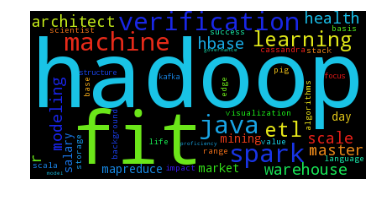

In [531]:
freq = {}
num_data_jobs = len(relevant_links)
for index, feature in enumerate (data_specific_features):
    freq[feature] = int (num_data_jobs*math.exp (-feature_score[feature]))

sorted_freq = collections.OrderedDict (sorted(freq.items(), key=lambda t: t[1]))
for keys, values in sorted_freq.items():
    print ("{} - {}".format (keys, values))

wordcloud = WordCloud().generate_from_frequencies (frequencies=list (freq.items()))
plt.imshow (wordcloud)
plt.axis ("off")